In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms

import albumentations as albu
from albumentations.pytorch import ToTensor

from PIL import Image

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# PytorchでNNモデルを作成して、学習する手順

## やること
### 1. データの読み込み
### 2. モデルの作成
### 3. 学習
### 4. 評価
### 5. モデルの保存
### 6. 検証

# 1. データの読み込み

## 使うライブラリ
- torch.utils.data.Dataset()
- torch.utils.data.DataLoader()



In [2]:
digits = load_digits()

X = digits.data
y = digits.target

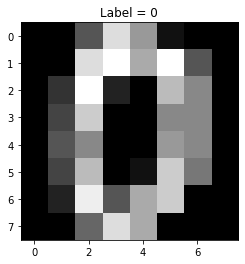

In [3]:
plt.title(f"Label = {y[0]}")
plt.imshow(X[0].reshape(8,8), cmap="gray")
plt.show()

In [4]:
X = X.reshape(-1, 8, 8, 1).astype(np.float32)

In [5]:
#学習用データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)


## 画像

## Ver albumentations

In [6]:
def train_augmentation():
    transform = [
        albu.Resize(32,32),
        albu.Normalize(mean=(0.485,), std=(0.229,)),
        ToTensor(),
    ]
    return albu.Compose(transform)

def test_augmentation():
    transform = [
        albu.Resize(32,32),
        albu.Normalize(mean=(0.485,), std=(0.229,)),
        ToTensor(),
    ]
    return albu.Compose(transform)

In [7]:
class MNIST(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, trans, flag=True):
        super().__init__()
        
        self.flag = flag
        self.trans = trans
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        
        if self.flag:
            image = self.images[idx]
            label = self.labels[idx]
            image = self.trans(image=image)['image']
            return image, label
        else:
            image = self.images[idx]
            image = self.trans(image=image)['image']
            return image

In [8]:
train_loader = torch.utils.data.DataLoader(MNIST(X_train, y_train, train_augmentation(), flag=True), batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(MNIST(X_valid, y_valid, train_augmentation(), flag=True), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST(X_test, False, test_augmentation(), flag=False), batch_size=1, shuffle=False)

In [9]:
# ネットワークの定義
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        #畳み込み層
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        #全結合層
        self.dence = nn.Sequential(
            nn.Linear(32 * 6 * 6, 128),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.2),
            nn.Linear(64, 10),
        )
         
    #順伝播
    def forward(self,x):
         
        out = self.conv_layers(x)
        #Flatten
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
         
        return out
     
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
         
        return out

## 確認

In [10]:
#デバイスの状態を確定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
#net()をデバイスに渡す
model = CNNNet().to(device)
 
#畳み込み層の出力サイズ=全結合層のinput_sizeの確認
size_check = torch.FloatTensor(10, 1, 32, 32)
size_check = size_check.to(device)
print(model.check_cnn_size(size_check).size())

torch.Size([10, 32, 6, 6])


In [11]:
#==== deviceの選択 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#==== モデルの定義 ====
model = CNNNet().to(device)

#==== 損失関数の定義 ====
criterion = nn.CrossEntropyLoss()

#==== Optimizerの定義 ====
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
#==== 学習 ====
def learning(train_loader, val_loader, num_epochs=100):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        valid_loss = 0
        valid_acc = 0
        
        
        #==== 学習 ====
        model.train()
        
        for images, labels in train_loader:
            #==== deviceに渡す
            images = images.to(device)
            labels = labels.to(device)
            
            #==== Optimizerの初期化 ====
            optimizer.zero_grad()
            
            #==== forward processing ====
            outputs = model(images)
            
            #==== Loss calcuration ====
            loss = criterion(outputs, labels)
            
            #==== backward processing ====
            loss.backward()
            
            #==== update optimizer ====
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        #==== 検証 =====
        model.eval()
        
        #重みを変えさせない
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_acc += (outputs.max(1)[1] == labels).sum().item()
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc = valid_acc / len(valid_loader.dataset)
        
        print(f"=====  epoch: {epoch+1} ===== \
        \n train_loss: {avg_train_loss}, valid_loss: {avg_valid_loss} \
        \n train_acc: {avg_train_acc}, valid_acc: {avg_valid_acc}")
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    loss_list = [train_loss_list, valid_loss_list]
    acc_list = [train_acc_list, valid_acc_list]
    
    return loss_list, acc_list

In [13]:
loss_list, acc_list = learning(train_loader, valid_loader, 150)

=====  epoch: 1 =====         
 train_loss: 0.036694951555622156, valid_loss: 0.03739705240284955         
 train_acc: 0.10248756218905472, valid_acc: 0.1087962962962963
=====  epoch: 2 =====         
 train_loss: 0.036631486902189495, valid_loss: 0.03739280888327846         
 train_acc: 0.09353233830845771, valid_acc: 0.08101851851851852
=====  epoch: 3 =====         
 train_loss: 0.036628229701103854, valid_loss: 0.03742511018558785         
 train_acc: 0.11641791044776119, valid_acc: 0.10648148148148148
=====  epoch: 4 =====         
 train_loss: 0.036604921616131984, valid_loss: 0.037431825090337684         
 train_acc: 0.10945273631840796, valid_acc: 0.0787037037037037
=====  epoch: 5 =====         
 train_loss: 0.03656468794713566, valid_loss: 0.03731504358627178         
 train_acc: 0.11940298507462686, valid_acc: 0.08101851851851852
=====  epoch: 6 =====         
 train_loss: 0.03651927929019454, valid_loss: 0.03728124333752526         
 train_acc: 0.11641791044776119, valid_ac

=====  epoch: 50 =====         
 train_loss: 0.0026956295047826434, valid_loss: 0.004034136490965331         
 train_acc: 0.9482587064676616, valid_acc: 0.9282407407407407
=====  epoch: 51 =====         
 train_loss: 0.002795185378534877, valid_loss: 0.004092381853196356         
 train_acc: 0.9462686567164179, valid_acc: 0.9189814814814815
=====  epoch: 52 =====         
 train_loss: 0.0027183680910969257, valid_loss: 0.004887411491600452         
 train_acc: 0.9522388059701492, valid_acc: 0.9074074074074074
=====  epoch: 53 =====         
 train_loss: 0.002664111954952354, valid_loss: 0.005346899162288065         
 train_acc: 0.9522388059701492, valid_acc: 0.9050925925925926
=====  epoch: 54 =====         
 train_loss: 0.002349996070067088, valid_loss: 0.0044680340905432344         
 train_acc: 0.9621890547263682, valid_acc: 0.9236111111111112
=====  epoch: 55 =====         
 train_loss: 0.0022460554147241125, valid_loss: 0.004423675403274872         
 train_acc: 0.9582089552238806, 

=====  epoch: 98 =====         
 train_loss: 0.0004759870219364095, valid_loss: 0.004127825282652069         
 train_acc: 0.9960199004975124, valid_acc: 0.9328703703703703
=====  epoch: 99 =====         
 train_loss: 0.00041771389506942597, valid_loss: 0.003705868583724455         
 train_acc: 0.9950248756218906, valid_acc: 0.9398148148148148
=====  epoch: 100 =====         
 train_loss: 0.0005030120773917406, valid_loss: 0.0037723136203432523         
 train_acc: 0.9940298507462687, valid_acc: 0.9351851851851852
=====  epoch: 101 =====         
 train_loss: 0.00041287116595168613, valid_loss: 0.003468442285709359         
 train_acc: 0.9970149253731343, valid_acc: 0.9421296296296297
=====  epoch: 102 =====         
 train_loss: 0.0004698195239871889, valid_loss: 0.0036464626038516007         
 train_acc: 0.9930348258706467, valid_acc: 0.9398148148148148
=====  epoch: 103 =====         
 train_loss: 0.0005699093634290482, valid_loss: 0.0041331891487869955         
 train_acc: 0.9930348

=====  epoch: 149 =====         
 train_loss: 8.913846408475691e-05, valid_loss: 0.004951950680050585         
 train_acc: 1.0, valid_acc: 0.9398148148148148
=====  epoch: 150 =====         
 train_loss: 7.816722908460382e-05, valid_loss: 0.004539763968851831         
 train_acc: 1.0, valid_acc: 0.9375


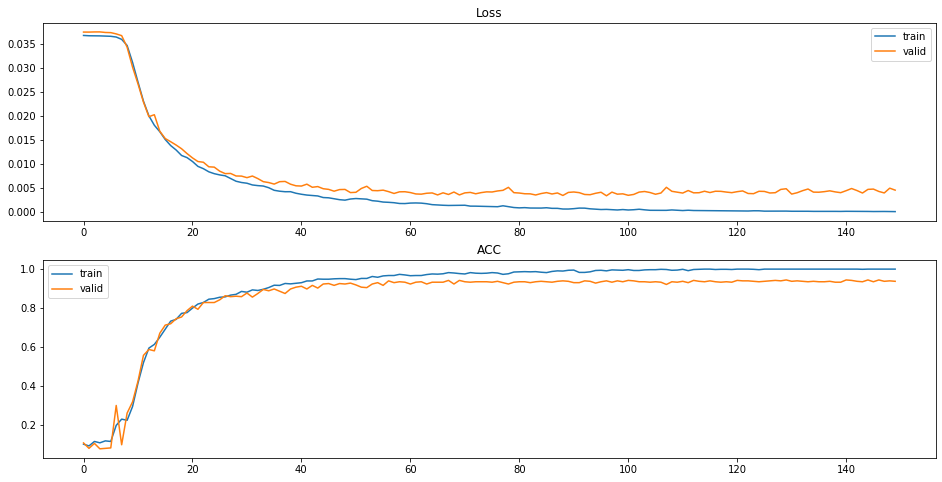

In [14]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(loss_list[0], label="train")
plt.plot(loss_list[1], label="valid")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("ACC")
plt.plot(acc_list[0], label="train")
plt.plot(acc_list[1], label="valid")
plt.legend()

plt.show()

In [195]:
#====== 保存 =======
torch.save(model.state_dict(), "model_cnn.pth")

In [ ]:
#==== deviceの選択 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#==== modelの定義
model = CNNNet()
#====== ロード =======
model.load_state_dict(torch.load("model_cnn.pth", map_location=device))

In [200]:
def prediction(test_loader):
    pred_list = []
    model.eval()
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model.forward(images)
            _, pred = torch.max(outputs.data, 1)
            pred_list.append(pred.item())
    return pred_list

In [201]:
pred = prediction(test_loader)

In [202]:
from sklearn.metrics import accuracy_score

In [203]:
accuracy_score(pred, y_test)

0.9638888888888889

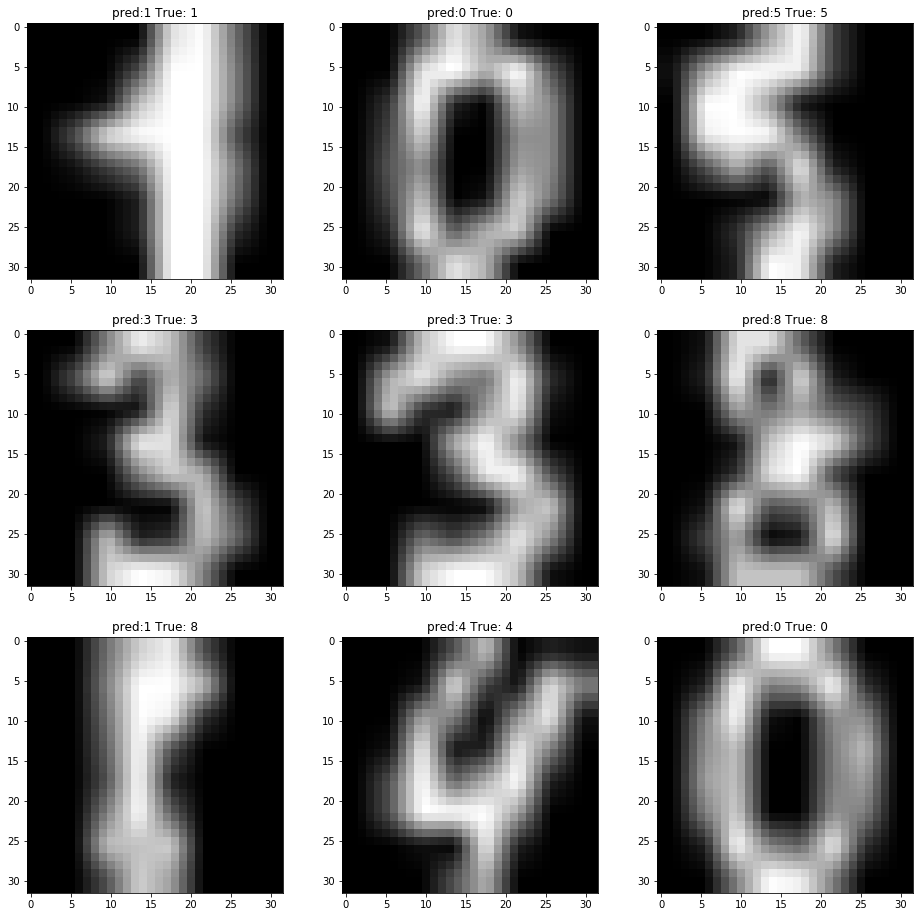

In [221]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(test_loader):
    plt.subplot(3, 3, i+1)
    plt.title(f"pred:{pred[i]} True: {y_test[i]}")
    plt.imshow(image.reshape(32,32), cmap="gray")
    
    if i+1 == 9:
        plt.show()
        break